とけたら dual も頑張って式変形して解きたい

# __まず cvxpy をつかってみる__

# 0 <= p_j(x_s) <= 1 は確認できた．任意の x に対して，p_j(x) \in [0, 1] とは限らないので，はみ出る場合は [0, 1] に clamp すればよいのか

# 各 p_j の実装

# 決定領域の可視化

$\displaystyle <w, x> + b = 0 \iff x_2 = -\frac{w_1}{w_2} x_1 - \frac{b}{w_2}$

# 係数を文字で代入した dataframe を作成し，最終的な行列の確認に使用する

In [3]:
import os 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cvxpy as cp
from cvxopt import matrix
from cvxopt.solvers import qp

%matplotlib inline
pd.set_option("display.max_rows",100)
pd.set_option("display.max_columns",100)

In [175]:
# load and convert data, describe problem settings, etc
data_dir_path = './inputs/toy_data/'
path_L1 = os.path.join(data_dir_path, 'L1.csv')
path_L2 = os.path.join(data_dir_path, 'L2.csv')
path_L3 = os.path.join(data_dir_path, 'L3.csv')
path_U = os.path.join(data_dir_path, 'U.csv')

df_L1 = pd.read_csv(path_L1, index_col=0)
df_L2 = pd.read_csv(path_L2, index_col=0)
df_L3 = pd.read_csv(path_L3, index_col=0)
df_U = pd.read_csv(path_U, index_col=0)

L1 = np.array(df_L1)
L2 = np.array(df_L2)
L3 = np.array(df_L3)

L = np.stack([L1, L2, L3]) # data for pointwise constraint
U = np.array(df_U) # data for logcal constriant


t = 3 # number of tasks 
v = 2 # number of logical constraints considered (cardinality of KB)
ns = 0 # number of pointwise constraints to be counted later


l = [] # L_j の要素数のリスト
s = [] # S_j の要素数のリスト
S = [] # data for consistency constraints

for i in range(t):
    if v != 0:
        u = len(U)
        S_i = np.concatenate((L[i][:, :2], U), axis=0)
        S.append(S_i)
    else:
        u = 0
        S_i = L[i][:, :2]
        S.append(S_i)
    l.append(len(L[i]))
    ns += len(L[i])
    s.append(len(S_i))

S = np.stack(S)


# c1 = 2.5 # degree of satisfaction for pointwise slacks
# c2 = 2.5 # degree of satisfaction for logical slacks

c1 = 100
c2 = 100


lb = np.zeros((3 * t + ns + v, 1)) # lower bounds for variables to be optimized
ub = np.zeros((3 * t + ns + v, 1)) # upper bounds for variables to be optimized

for i in range(3 * t):
    lb[i, 0] = -100000
    ub[i, 0] = 100000

for i in range(3 * t, 3 * t + ns + v):
    lb[i, 0] = 0
    ub[i, 0] = 100000

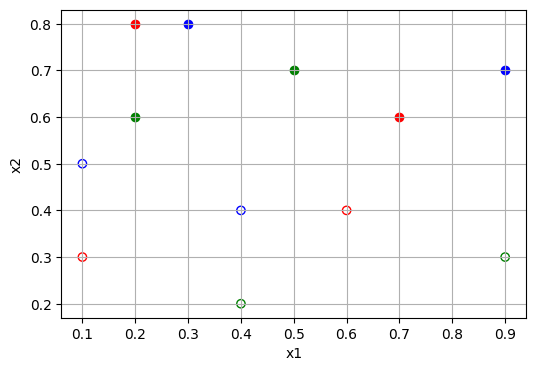

In [102]:
# # supervised data (L) の可視化

# plt.figure(figsize=(6,4))
# colors = ['blue', 'red', 'green']

# for j in range(t):
#     for l in range(4):
#         if L[j][l, 2] == 1:
#             plt.scatter(L[j][l, 0], L[j][l, 1], c=colors[j], marker='o', label='1')
#         else:
#             plt.scatter(L[j][l, 0], L[j][l, 1], facecolors='none', edgecolors=colors[j], marker='o', label='-1')


# plt.xlabel("x1")
# plt.ylabel("x2")
# plt.grid(True)
# plt.show()

In [176]:
# 目的関数の定義
# 1/2 x.T @ P @ x + q.T @ x
# の P と q を定義
# x = [w_{j1}, w_{j2}, b_j, ξ_{jl}, ξ_h] 
# len(x) = 23

H = np.zeros((3 * t + ns + v, 3 * t + ns + v))

for i in range(3 * t):
    if (i + 1) % 3 != 0:
        H[i, i] = 1


f = np.zeros((3 * t + ns + v, 1))

for i in range(3 * t + ns):
    f[i, 0] = c1

for i in range(3 * t + ns, 3 * t + ns + v, 1):
    f[i, 0] = c2

In [178]:
# 制約の定義
# A @ x <= b

# A の行数，つまり制約不等式の本数
A_shape_0 = 0
for i in range(t):
    A_shape_0 += l[i]

for i in range(t):
    A_shape_0 += 2 * s[i]

for i in range(v):
    A_shape_0 += u


A = np.zeros((A_shape_0, 3 * t + ns + v))
b = np.zeros((A_shape_0, 1))
count = 0 # 制約条件の行数カウンタ


# pointwise constraints
for i in range(t):
    k = 3 * i
    for j in range(l[i]):
        A[j + count, k]     = -2 * L[i][j, 0] * L[i][j, 2]
        A[j + count, k + 1] = -2 * L[i][j, 1] * L[i][j, 2]
        A[j + count, k + 2] = -2 * L[i][j, 2]
        A[j + count, count + j + 3 * t] = -2
        b[j + count, 0] = -1 - L[i][j, 2]
    count += l[i]


# consistency constraints
if v > 0:
    for i in range(t):
        k = 3 * i
        for j in range(s[i]):
            A[j + count, k] = S[i, j, 0]
            A[j + count, k + 1] = S[i, j, 1]
            A[j + count, k + 2] = 1
            b[j + count, 0] = 1
            A[j + count + s[i], k] = - S[i, j, 0]
            A[j + count + s[i], k + 1] = - S[i, j, 1]
            A[j + count + s[i], k + 2] = - 1
            b[j + count + s[i], 0] = 0

        #     print(f'j + count: {j + count}')
        #     print(f'j + count + s[i]: {j + count + s[i]}')
        # print()

        count += 2 * s[i]


# logical constraints
if v > 0:
    for i in range(v):
        k = 3 * i
        for j in range(u):
            A[j + count, k] = U[j, 0]
            A[j + count, k + 1] = U[j, 1]
            A[j + count, k + 2] = 1
            A[j + count, k + 3] = -U[j, 0]
            A[j + count, k + 4] = -U[j, 1]
            A[j + count, k + 5] = -1
            A[j + count, 3 * t + ns + i] = -1
            b[j + count, 0] = 0

            # print(f'k: {k, k+1, k+2, k+3, k+4, k+5}')
            # print(f'3*t+ns+i: {3*t+ns+i}')
            # print()

        count += u

In [191]:
tmp_x = np.array(sol['x'])
tmp_x

array([[ 1.79537803e-08],
       [ 1.01928438e-07],
       [-2.99755666e-08],
       [-5.50106313e-07],
       [ 2.73477944e-07],
       [ 4.47096667e-07],
       [-1.11111110e+00],
       [ 3.70370390e-01],
       [ 9.25925911e-01],
       [ 2.59837040e-08],
       [ 2.11769943e-08],
       [ 9.99999946e-01],
       [ 9.99999946e-01],
       [ 4.77329093e-07],
       [ 2.29623730e-07],
       [ 9.99999447e-01],
       [ 9.99999777e-01],
       [ 5.55555554e-01],
       [ 3.70370450e-02],
       [ 7.40740776e-02],
       [ 3.70370367e-01],
       [ 2.02003958e-08],
       [ 3.59596842e-08]])

In [193]:
arr = A @ tmp_x - b
max(arr)

array([-2.76761777e-09])

In [ ]:
# w = cp.Variable(shape=(3 * t, 1))
# xi_1 = cp.Variable(shape=(ns, 1))
# xi_2 = cp.Variable(shape=(v, 1))

# x = cp.vstack([w, xi_1, xi_2])

# objective_function = cp.Minimize(1/2 * cp.quad_form(x, H) + f.T @ x)

# constraints = [
#     A @ x <= b
# ]

# problem = cp.Problem(objective_function, constraints)
# result = problem.solve(verbose=True)

In [180]:
P = matrix(H)
q = matrix(f)
G = matrix(A)
h = matrix(b)

sol = qp(P=P, q=q, G=G, h=h)

print()
print(sol)

     pcost       dcost       gap    pres   dres
 0: -3.8230e+04  1.2153e+04  6e+04  6e+01  5e-01
 1: -3.8130e+03  1.2007e+02  8e+03  8e+00  6e-02
 2:  4.4700e+02  2.6587e+02  7e+02  3e-01  3e-03
 3:  5.1661e+02  3.9572e+02  3e+02  1e-01  1e-03
 4:  5.3745e+02  4.8563e+02  7e+01  2e-02  1e-04
 5:  5.3052e+02  5.1309e+02  2e+01  4e-03  3e-05
 6:  5.2312e+02  5.2267e+02  5e-01  5e-05  4e-07
 7:  5.2291e+02  5.2291e+02  5e-03  5e-07  4e-09
 8:  5.2291e+02  5.2291e+02  5e-05  5e-09  4e-11
Optimal solution found.

{'x': <23x1 matrix, tc='d'>, 'y': <0x1 matrix, tc='d'>, 's': <84x1 matrix, tc='d'>, 'z': <84x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 4.98719039969553e-05, 'relative gap': 9.537413336318599e-08, 'primal objective': 522.9081146189083, 'dual objective': 522.908069917054, 'primal infeasibility': 5.146968949197904e-09, 'dual infeasibility': 3.943441307944365e-11, 'primal slack': 6.894373799532851e-09, 'dual slack': 3.631662845565776e-07, 'iterations': 8}


In [108]:
list(sol['x'])

[2.5952498463909757e-08,
 2.2199551409348547e-07,
 -5.7879903360728176e-08,
 -3.6610074298621765e-06,
 1.491353572241256e-06,
 3.00568302826127e-06,
 -1.111110949053512,
 0.37037069719167204,
 0.9259257253901824,
 6.404882373430996e-08,
 4.963502186412762e-08,
 0.9999998808334627,
 0.999999887461515,
 3.095324077149319e-06,
 1.4139557194423682e-06,
 0.9999965417713201,
 0.9999986705457494,
 0.5555554935428322,
 0.03703708873524341,
 0.07407405444123699,
 0.37037026943812346,
 2.158727715857753e-08,
 5.899922174346646e-09]

In [172]:
coeff_p1 = vars[:3]
coeff_p1

[2.5952498463909757e-08, 2.2199551409348547e-07, -5.7879903360728176e-08]

In [174]:
w1 = coeff_p1[0]
w2 = coeff_p1[1]
b = coeff_p1[2]

-w1/w2, -b/w2 + 0.5/w2

(-0.11690550851843245, 2252298.024676959)

In [164]:
vars = list(sol['x'])

In [169]:
xi_j = vars[9:21]
xi_j

[6.404882373430996e-08,
 4.963502186412762e-08,
 0.9999998808334627,
 0.999999887461515,
 3.095324077149319e-06,
 1.4139557194423682e-06,
 0.9999965417713201,
 0.9999986705457494,
 0.5555554935428322,
 0.03703708873524341,
 0.07407405444123699,
 0.37037026943812346]

In [170]:
cnt = 0

for val in xi_j:
    if val >= 0.5:
        cnt += 1

cnt

5

In [181]:
coeff_0 = list(sol['x'])[:3]
coeff_1 = list(sol['x'])[3:6]
coeff_2 = list(sol['x'])[6:9]

coeff_0, coeff_1, coeff_2


([1.7953780289658155e-08, 1.0192843817840004e-07, -2.997556655183496e-08],
 [-5.501063132273276e-07, 2.7347794374029815e-07, 4.4709666734338843e-07],
 [-1.1111110954761274, 0.37037039006807365, 0.9259259106825177])

In [182]:
# 0 <= p_j(x_s) <= 1 の確認

def p(x, coeff):
    w_1 = coeff[0]
    w_2 = coeff[1]
    b = coeff[2]
    return w_1 * x[0] + w_2 * x[1] + b

coeff_0 = list(sol['x'])[:3]
coeff_1 = list(sol['x'])[3:6]
coeff_2 = list(sol['x'])[6:9]
coeffs = [coeff_0, coeff_1, coeff_2]

for j in range(3):
    for x_s in S[j]:
        tmp_val = p(x_s, coeffs[j])
        if tmp_val < 0:
            print(f'p_{j}({x_s}) is less than 0')
            print(tmp_val)
            print()
        if tmp_val > 1:
            print(f'p_{j}({x_s}) is more than 1')
            print(tmp_val)
            print()
        else:
            pass

In [186]:
def boundary_equation_2d(x1, coeff):
    w1 = coeff[0]
    w2 = coeff[1]
    b = coeff[2]

    x = np.hstack([x1, np.ones_like(x1)])
    # w = np.array([-w1/w2, -b/w2]).reshape(-1,1)
    w = np.array([-w1/w2, -b/w2 + 0.5/w2]).reshape(-1,1)

    return x @ w

In [187]:
test_x = np.linspace(0.05, 0.95, 100).reshape(-1,1)

test_y_1 = boundary_equation_2d(test_x, coeff_0)
test_y_2 = boundary_equation_2d(test_x, coeff_1)
test_y_3 = boundary_equation_2d(test_x, coeff_2)
# test_y_1 = boundary_equation_2d(test_x, coeff_0) 
# test_y_2 = boundary_equation_2d(test_x, coeff_1)
# test_y_3 = boundary_equation_2d(test_x, coeff_2)

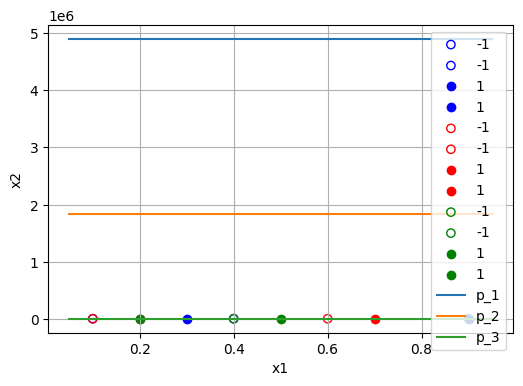

In [188]:
plt.figure(figsize=(6,4))
colors = ['blue', 'red', 'green']

for j in range(t):
    for l in range(4):
        if L[j][l, 2] == 1:
            plt.scatter(L[j][l, 0], L[j][l, 1], c=colors[j], marker='o', label='1')
        else:
            plt.scatter(L[j][l, 0], L[j][l, 1], facecolors='none', edgecolors=colors[j], marker='o', label='-1')

plt.plot(test_x, test_y_1, label="p_1")
plt.plot(test_x, test_y_2, label="p_2")
plt.plot(test_x, test_y_3, label="p_3")


plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.show()

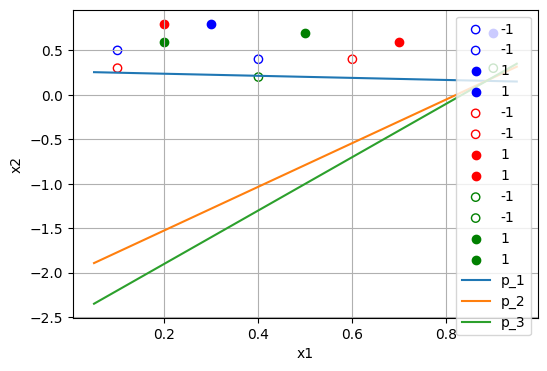

In [163]:
plt.figure(figsize=(6,4))
colors = ['blue', 'red', 'green']

for j in range(t):
    for l in range(4):
        if L[j][l, 2] == 1:
            plt.scatter(L[j][l, 0], L[j][l, 1], c=colors[j], marker='o', label='1')
        else:
            plt.scatter(L[j][l, 0], L[j][l, 1], facecolors='none', edgecolors=colors[j], marker='o', label='-1')

plt.plot(test_x, test_y_1, label="p_1")
plt.plot(test_x, test_y_2, label="p_2")
plt.plot(test_x, test_y_3, label="p_3")


plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.show()

In [127]:
test_x = np.array([0.4, 1])
p(test_x, coeff_0)

1.744966101183212e-07

# $\forall x \in [0,1]^2, 0 \leq p_j(x)$

In [129]:
tmp = np.linspace(0, 1, 100)
xx1, xx2 = np.meshgrid(tmp, tmp)

In [135]:
tmp_vals = np.hstack([xx1.ravel().reshape(-1,1), xx2.ravel().reshape(-1,1)])
tmp_vals

array([[0.        , 0.        ],
       [0.01010101, 0.        ],
       [0.02020202, 0.        ],
       ...,
       [0.97979798, 1.        ],
       [0.98989899, 1.        ],
       [1.        , 1.        ]])

In [141]:
tmp_lists = []
for j in range(3):
    tmp_list = []
    for tmp_val in tmp_vals:
        tmp_list.append(p(tmp_val, coeffs[j]))
    tmp_lists.append(tmp_list)

In [144]:
tmp_df = pd.DataFrame(tmp_lists).T
tmp_df

,0,1,2
0,-5.787990e-08,3.005683e-06,0.925926
1,-5.761776e-08,2.968703e-06,0.914702
2,-5.735561e-08,2.931723e-06,0.903479
3,-5.709346e-08,2.894743e-06,0.892256
4,-5.683132e-08,2.857764e-06,0.881032
...,...,...,...
9995,1.890195e-07,9.839487e-07,0.230079
9996,1.892817e-07,9.469688e-07,0.218856
9997,1.895438e-07,9.099889e-07,0.207632
9998,1.898060e-07,8.730090e-07,0.196409


In [145]:
tmp_df.min()

0   -5.787990e-08
1   -6.553244e-07
2   -1.851852e-01
dtype: float64

In [146]:
tmp_df.max()

0    1.900681e-07
1    4.497037e-06
2    1.296296e+00
dtype: float64

In [2]:
L1 = [(0.1, 0.5, -1), (0.4, 0.4, -1), (0.3, 0.8, 1), (0.9, 0.7, 1)]
L2 = [(0.1, 0.3, -1), (0.6, 0.4, -1), (0.2, 0.8, 1), (0.7, 0.6, 1)]
L3 = [(0.4, 0.2, -1), (0.9, 0.3, -1), (0.2, 0.6, 1), (0.5, 0.7, 1)]
U = [(0.1, 0.5), (0.3, 0.7), (0.5, 0.4), (0.8, 0.3), (0.9, 0.2), (1, 0.5)]

L1 = np.array(L1)
L2 = np.array(L2)
L3 = np.array(L3)
L = np.stack([L1, L2, L3])

U = np.array(U)

t = 3  # number of tasks (p_j の数)
v = 2  # number of logical constraints considered (おそらく phi の数, KB の要素数)
ns = 0  # number of pointwise constraints (これからカウントする)

print('L: ')
display(L)
print()

print('U: ')
display(U)

L: 


array([[[ 0.1,  0.5, -1. ],
        [ 0.4,  0.4, -1. ],
        [ 0.3,  0.8,  1. ],
        [ 0.9,  0.7,  1. ]],

       [[ 0.1,  0.3, -1. ],
        [ 0.6,  0.4, -1. ],
        [ 0.2,  0.8,  1. ],
        [ 0.7,  0.6,  1. ]],

       [[ 0.4,  0.2, -1. ],
        [ 0.9,  0.3, -1. ],
        [ 0.2,  0.6,  1. ],
        [ 0.5,  0.7,  1. ]]])


U: 


array([[0.1, 0.5],
       [0.3, 0.7],
       [0.5, 0.4],
       [0.8, 0.3],
       [0.9, 0.2],
       [1. , 0.5]])

In [3]:
L1_df = pd.DataFrame(L1)
L2_df = pd.DataFrame(L2)
L3_df = pd.DataFrame(L3)
U_df = pd.DataFrame(U)

L1_df.to_csv('./inputs/toy_data/L1.csv')
L2_df.to_csv('./inputs/toy_data/L2.csv')
L3_df.to_csv('./inputs/toy_data/L3.csv')
U_df.to_csv('./inputs/toy_data/U.csv')

In [4]:
l = []
s = []
ns = 0
S = []

for i in range(t):
    if v != 0:
        u = len(U)
        S_i = np.concatenate((L[i][:, :2], U), axis=0)
        S.append(S_i)
    else:
        u = 0
        S_i = L[i][:, :2]
        S.append(S_i)
    l.append(len(L[i]))
    ns += len(L[i])
    s.append(len(S_i))

S = np.stack(S)

print(f'l: {l}')
print(f's: {s}')
print(f'ns: {ns}')
print()
display(S)

l: [4, 4, 4]
s: [10, 10, 10]
ns: 12



array([[[0.1, 0.5],
        [0.4, 0.4],
        [0.3, 0.8],
        [0.9, 0.7],
        [0.1, 0.5],
        [0.3, 0.7],
        [0.5, 0.4],
        [0.8, 0.3],
        [0.9, 0.2],
        [1. , 0.5]],

       [[0.1, 0.3],
        [0.6, 0.4],
        [0.2, 0.8],
        [0.7, 0.6],
        [0.1, 0.5],
        [0.3, 0.7],
        [0.5, 0.4],
        [0.8, 0.3],
        [0.9, 0.2],
        [1. , 0.5]],

       [[0.4, 0.2],
        [0.9, 0.3],
        [0.2, 0.6],
        [0.5, 0.7],
        [0.1, 0.5],
        [0.3, 0.7],
        [0.5, 0.4],
        [0.8, 0.3],
        [0.9, 0.2],
        [1. , 0.5]]])

In [5]:
c1=2.5;  # degree of satisfaction for pointwise slacks
c2=2.5;  # degree of satisfaction for logical slacks

In [6]:
# Initialize lb and ub as arrays of zeros
lb = np.zeros(0)
ub = np.zeros(0)

lb = np.zeros((3 * t + ns + v, 1))
ub = np.zeros((3 * t + ns + v, 1))

# Set lb and ub values using loops
for i in range(3 * t):
    lb[i, 0] = -100000
    ub[i, 0] = 100000

for i in range(3 * t, 3 * t + ns + v):
    lb[i, 0] = 0
    ub[i, 0] = 100000

print(f'lb: ')
display(lb)
print()
print(f'ub: ')
display(ub)

lb: 


array([[-100000.],
       [-100000.],
       [-100000.],
       [-100000.],
       [-100000.],
       [-100000.],
       [-100000.],
       [-100000.],
       [-100000.],
       [      0.],
       [      0.],
       [      0.],
       [      0.],
       [      0.],
       [      0.],
       [      0.],
       [      0.],
       [      0.],
       [      0.],
       [      0.],
       [      0.],
       [      0.],
       [      0.]])


ub: 


array([[100000.],
       [100000.],
       [100000.],
       [100000.],
       [100000.],
       [100000.],
       [100000.],
       [100000.],
       [100000.],
       [100000.],
       [100000.],
       [100000.],
       [100000.],
       [100000.],
       [100000.],
       [100000.],
       [100000.],
       [100000.],
       [100000.],
       [100000.],
       [100000.],
       [100000.],
       [100000.]])

In [11]:
w = cp.Variable(shape=(3 * t, 1))
xi_1 = cp.Variable(shape=(ns, 1))
xi_2 = cp.Variable(shape=(v, 1))


w, xi_1, xi_2

(Variable((9, 1)), Variable((12, 1)), Variable((2, 1)))

In [13]:
x = cp.vstack([w, xi_1, xi_2])
x

Expression(AFFINE, UNKNOWN, (23, 1))

In [34]:
objective_function = cp.Minimize(1/2 * cp.quad_form(x, H) + f.T @ x)

constraints = [
    A @ x <= b
]

problem = cp.Problem(objective_function, constraints)
result = problem.solve(verbose=True)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Sep 29 12:23:42 PM: Your problem has 23 variables, 1 constraints, and 0 parameters.
(CVXPY) Sep 29 12:23:42 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 29 12:23:42 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 29 12:23:42 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Sep 29 12:23:42 PM: Compiling problem (target solver=OSQP).
(CVXPY) Sep 29 12:23:42 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing

In [44]:
x[0,0].value

3.240927438696496e-08

In [15]:
H = np.zeros((3 * t + ns + v, 3 * t + ns + v))

for i in range(3 * t):
    if (i + 1) % 3 != 0:
        H[i, i] = 1

pd.DataFrame(H)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


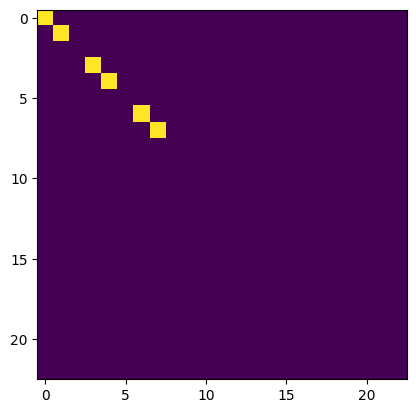

In [16]:
H_shape_vis = np.full((3 * t + ns + v, 3 * t + ns + v), False, dtype=bool)

for i in range(3 * t):
    if (i + 1) % 3 != 0:
        H_shape_vis[i, i] = True

plt.figure()
plt.imshow(H_shape_vis)
plt.show()

In [17]:
f = np.zeros((3 * t + ns + v, 1))

for i in range(3 * t + ns):
    f[i, 0] = c1

for i in range(3 * t + ns, 3 * t + ns + v, 1):
    f[i, 0] = c2

print(f'f: ')
display(f.T)

f: 


array([[2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5,
        2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5]])

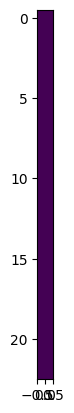

In [18]:
f_shape_vis = np.zeros((3 * t + ns + v, 1))

for i in range(3 * t + ns):
    f_shape_vis[i, 0] = True

for i in range(3 * t + ns, 3 * t + ns + v, 1):
    f_shape_vis[i, 0] = True

plt.figure()
plt.imshow(f_shape_vis)
plt.show()

In [19]:
import numpy as np





tmp = 84

A = np.zeros((tmp, 3 * t + ns + v))
b = np.zeros((tmp, 1))
count = 0  # 制約条件の行数カウンタ


# POINTWISE CONSTRAINTS
for i in range(t):
    k = 3 * i
    for j in range(l[i]):
        A[j + count, k] = -2 * L[i][j, 0] * L[i][j, 2]
        A[j + count, k + 1] = -2 * L[i][j, 1] * L[i][j, 2]
        A[j + count, k + 2] = -2 * L[i][j, 2]
        A[j + count, count + j + 3 * t] = -2
        b[j + count, 0] = -1 - L[i][j, 2]
    count += l[i]


# CONCISTENCY CONSTRAINTS
if v > 0:
    for i in range(t):
        k = 3 * i
        for j in range(s[i]):
            A[j + count, k] = S[i, j, 0]
            A[j + count, k + 1] = S[i, j, 1]
            A[j + count, k + 2] = 1
            b[j + count, 0] = 1
            A[j + count + s[i], k] = - S[i, j, 0]
            A[j + count + s[i], k + 1] = - S[i, j, 1]
            A[j + count + s[i], k + 2] = - 1
            b[j + count + s[i], 0] = 0

        #     print(f'j + count: {j + count}')
        #     print(f'j + count + s[i]: {j + count + s[i]}')
        # print()

        count += 2 * s[i]


# LOGICAL CONSTRAINTS
if v > 0:
    for i in range(v):
        k = 3 * i
        for j in range(u):
            A[j + count, k] = U[j, 0]
            A[j + count, k + 1] = U[j, 1]
            A[j + count, k + 2] = 1
            A[j + count, k + 3] = -U[j, 0]
            A[j + count, k + 4] = -U[j, 1]
            A[j + count, k + 5] = -1
            A[j + count, 3 * t + ns + i] = -1
            b[j + count, 0] = 0

            print(f'k: {k, k+1, k+2, k+3, k+4, k+5}')
            print(f'3*t+ns+i: {3*t+ns+i}')
            print()

        count += u

k: (0, 1, 2, 3, 4, 5)
3*t+ns+i: 21

k: (0, 1, 2, 3, 4, 5)
3*t+ns+i: 21

k: (0, 1, 2, 3, 4, 5)
3*t+ns+i: 21

k: (0, 1, 2, 3, 4, 5)
3*t+ns+i: 21

k: (0, 1, 2, 3, 4, 5)
3*t+ns+i: 21

k: (0, 1, 2, 3, 4, 5)
3*t+ns+i: 21

k: (3, 4, 5, 6, 7, 8)
3*t+ns+i: 22

k: (3, 4, 5, 6, 7, 8)
3*t+ns+i: 22

k: (3, 4, 5, 6, 7, 8)
3*t+ns+i: 22

k: (3, 4, 5, 6, 7, 8)
3*t+ns+i: 22

k: (3, 4, 5, 6, 7, 8)
3*t+ns+i: 22

k: (3, 4, 5, 6, 7, 8)
3*t+ns+i: 22



In [20]:
pd.DataFrame(A)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.2,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.8,0.8,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.6,-1.6,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.8,-1.4,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.2,0.6,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.2,0.8,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,-0.4,-1.6,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,-1.4,-1.2,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,1.8,0.6,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0


In [21]:
pd.DataFrame(b)

,0
0,0.0
1,0.0
2,-2.0
3,-2.0
4,0.0
5,0.0
6,-2.0
7,-2.0
8,0.0
9,0.0


In [29]:
from cvxopt import matrix
from cvxopt.solvers import qp

P = matrix(H)
q = matrix(f)
G = matrix(A)
h = matrix(b)

sol = qp(P=P, q=q, G=G, h=h)

     pcost       dcost       gap    pres   dres
 0: -5.6126e+00  1.4832e+01  3e+02  3e+00  2e+00
 1:  2.7744e+01 -9.5758e+00  4e+01  4e-16  1e-15
 2:  1.6610e+01  1.0349e+01  6e+00  2e-16  9e-16
 3:  1.4773e+01  1.2608e+01  2e+00  2e-16  3e-15
 4:  1.3913e+01  1.3586e+01  3e-01  2e-16  6e-15
 5:  1.3755e+01  1.3733e+01  2e-02  2e-16  3e-14
 6:  1.3742e+01  1.3741e+01  3e-04  2e-16  6e-14
 7:  1.3741e+01  1.3741e+01  3e-06  2e-16  4e-14
Optimal solution found.


In [30]:
sol

{'x': <23x1 matrix, tc='d'>,
 'y': <0x1 matrix, tc='d'>,
 's': <84x1 matrix, tc='d'>,
 'z': <84x1 matrix, tc='d'>,
 'status': 'optimal',
 'gap': 2.8075770490943867e-06,
 'relative gap': 2.0431482829237698e-07,
 'primal objective': 13.741428589345128,
 'dual objective': 13.741425781768077,
 'primal infeasibility': 1.6273792271313773e-16,
 'dual infeasibility': 3.979653429625518e-14,
 'primal slack': 7.533222348535456e-09,
 'dual slack': 8.864810276976008e-09,
 'iterations': 7}

In [38]:
print(sol['x'])

[ 2.60e-08]
[ 2.22e-07]
[-5.79e-08]
[-3.66e-06]
[ 1.49e-06]
[ 3.01e-06]
[-1.11e+00]
[ 3.70e-01]
[ 9.26e-01]
[ 6.40e-08]
[ 4.96e-08]
[ 1.00e+00]
[ 1.00e+00]
[ 3.10e-06]
[ 1.41e-06]
[ 1.00e+00]
[ 1.00e+00]
[ 5.56e-01]
[ 3.70e-02]
[ 7.41e-02]
[ 3.70e-01]
[ 2.16e-08]
[ 5.90e-09]



# $p_j(\bold x)$ はそのまま

$$p_j(\bold x) = \omega_{j1} x_1 + \omega_{j2} x_2 + b_j$$